# Flight Routes in USA

Data:
https://openflights.org/data.html

In [153]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.lines as mlines

In [4]:
%%bash
ls data

airport_df.csv
airports.dat
routes.dat
routes_df.csv


In [145]:
df_airport = pd.read_csv("data/airport_df.csv")
df_routes = pd.read_csv("data/routes_df.csv")

print(df_routes.columns)
print(df_routes.head())

df_airport = df_airport[(df_airport.Country == "United States") & (df_airport.Lat > 25) & (df_airport.Lat < 50) & (df_airport.Long > -130) & (df_airport.Long < -60)]
print(df_airport.head())

airports_in_us = df_airport['IATA'].values

df_airport_ix = df_airport.index.values
print(df_airport_ix)

df_routes = df_routes[(df_routes['Source Airport ID'].isin(df_airport_ix)) & (df_routes['Dest Airport ID'].isin(df_airport_ix) & df_routes['Source Airport'].isin(airports_in_us)) & (df_routes['Dest Airport'].isin(airports_in_us))] 

df_routes =  pd.DataFrame(df_routes.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))

counts = df_routes['Source Airport'].append(df_routes.loc[df_routes['Source Airport'] != df_routes['Dest Airport'], 'Dest Airport']).value_counts()

counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})

pos_data = counts.merge(df_airport, on = 'IATA')
pos_data.to_csv("data/pos_data.csv",sep=",")

Index(['Unnamed: 0', 'Airline', 'Airline ID', 'Source Airport',
       'Source Airport ID', 'Dest Airport', 'Dest Airport ID', 'Codeshare',
       'Stops', 'equipment'],
      dtype='object')
   Unnamed: 0 Airline Airline ID Source Airport  Source Airport ID  \
0           0      2B        410            AER             2965.0   
1           1      2B        410            ASF             2966.0   
2           2      2B        410            ASF             2966.0   
3           3      2B        410            CEK             2968.0   
4           4      2B        410            CEK             2968.0   

  Dest Airport  Dest Airport ID Codeshare  Stops equipment  
0          KZN           2990.0       NaN      0       CR2  
1          KZN           2990.0       NaN      0       CR2  
2          MRV           2962.0       NaN      0       CR2  
3          KZN           2990.0       NaN      0       CR2  
4          OVB           4078.0       NaN      0       CR2  
        ID           

In [146]:
df_airport[ df_airport['IATA'] =='AAT' ]

,ID,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source


In [147]:
df_routes[ df_routes['Source Airport'] =='AAT' ]

,Source Airport,Dest Airport,counts


In [148]:
graph = nx.from_pandas_edgelist(df_routes, 'Source Airport', 'Dest Airport', edge_attr=True)

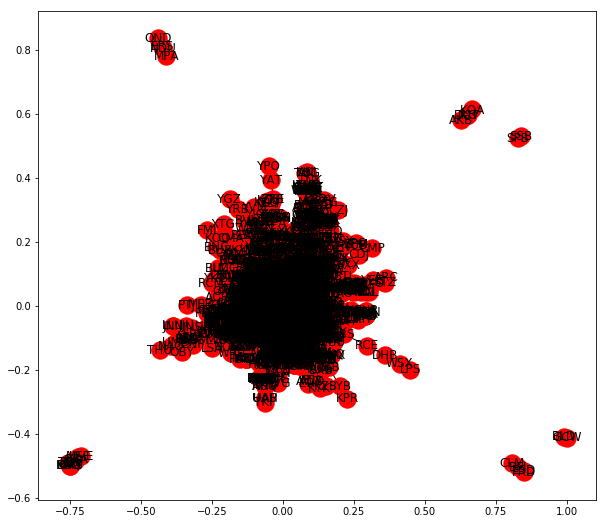

In [94]:
plt.figure(figsize = (10,9))
nx.draw_networkx(graph)
# plt.savefig("./images/map_0.png", format = "png", dpi = 300)
plt.show()

In [95]:
plt.figure(figsize = (10,9))
m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=10,urcrnrlon=-50,urcrnrlat=70, lat_ts=0, resolution='l',suppress_ticks=True)


<Figure size 720x648 with 0 Axes>

In [103]:
# pos_data = pd.read_csv("data/pos_data.csv")
# pos_data = pos_data.drop(['Unnamed: 0'],axis=1);

# pos_aer = pd.DataFrame([['AER', 0, '' , 43.4450,39.9439, ''],['KZN', 0, '' , 55.6086, 49.2984,''], ['ASF', 0, '' , 46.2870, 47.9999,''], ['MRV', 0, '' , 44.2178, 43.0877,''] ],columns = ['IATA', 'total_flight', 'Name', 'Lat', 'Long', 'ICAO'])
# pos_data = pd.concat([pos_aer,pos_data])


In [149]:
pos_data[pos_data['IATA'] == 'AAT']

,IATA,total_flight,ID,Name,City,Country,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source


In [150]:
mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)
pos = {}
for count, elem in enumerate (pos_data['IATA']):
     pos[elem] = (mx[count], my[count])

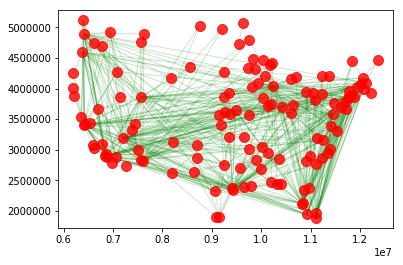

In [151]:
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(),node_color = 'r', alpha = 0.8, node_size = 100)
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='g', alpha=0.2, arrows = False)

In [177]:
crit = 90

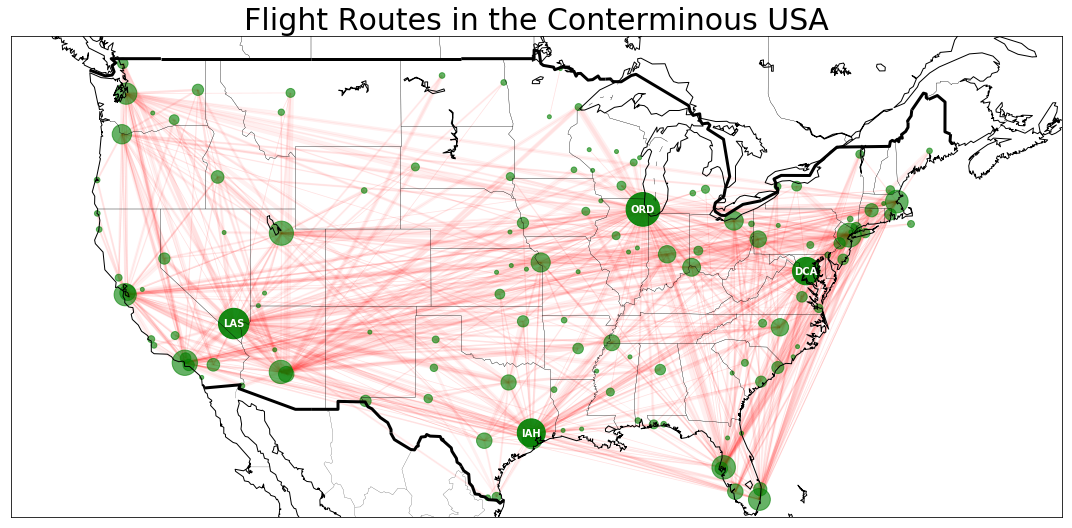

In [185]:
graph = nx.from_pandas_edgelist(df_routes, source = 'Source Airport', target = 'Dest Airport', edge_attr = 'counts',create_using = nx.DiGraph())

# Set up base map
plt.figure(figsize=(15,20))
m = Basemap(
        projection='merc',
        llcrnrlon=-130,
        llcrnrlat=25,
        urcrnrlon=-60,
        urcrnrlat=50,
        lat_ts=0,
        resolution='l',
        suppress_ticks=True)

# import long lat as m attribute
mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)
pos = {}
for count, elem in enumerate (pos_data['IATA']):
    pos[elem] = (mx[count], my[count])

# draw nodes and edges and overly on basemap
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] >= crit],
                       node_color = 'g', alpha = 0.9,
                       node_size = [counts['total_flight'][x]*8  for x in graph.nodes() if counts['total_flight'][x] >= crit])

nx.draw_networkx_labels(G = graph, pos = pos, font_size=10, font_color = 'w', font_weight='bold',
                        labels = {x:x for x in graph.nodes() if counts['total_flight'][x] >= crit})

nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] < crit],
                       node_color = 'g', alpha = 0.6,
                       node_size = [counts['total_flight'][x]*8  for x in graph.nodes() if counts['total_flight'][x] < crit])

nx.draw_networkx_edges(G = graph, pos = pos, edge_color = 'r', width = routes_us['counts']*0.75, alpha=0.06, arrows = False)

m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
# m.fillcontinents(alpha = 0.3)
line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue")
line3 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="green")
# plt.legend((line1, line2, line3), ('Large Airport > '+ str(crit) +' routes', 'Smaller airports', 'routes'), loc=4, fontsize = 'xx-large')
# plt.legend((line1, line2, line3), ('Large Airport > '+ str(crit) +' routes', 'Smaller airports', 'routes'), loc=4, fontsize = 'xx-large')
plt.title("Flight Routes in the Conterminous USA", fontsize = 30)


plt.tight_layout()
# plt.savefig("./images/networkx_basemap/map_3.png", format = "png", dpi = 300)
plt.show()

## References

1. https://towardsdatascience.com/catching-that-flight-visualizing-social-network-with-networkx-and-basemap-ce4a0d2eaea6